In [1]:
import numpy as np
from numpy.linalg import inv as inv
import scipy.io
import time

In [2]:
def kr_prod(a, b):
    return np.einsum('ir, jr -> ijr', a, b).reshape(a.shape[0] * b.shape[0], -1)

def TRMF(dense_mat, sparse_mat, init, time_lags, lambda_w, lambda_x, lambda_theta, eta, maxiter):
    W = init["W"]
    X = init["X"]
    theta = init["theta"]
    
    dim1, dim2 = sparse_mat.shape
    binary_mat = np.zeros((dim1,dim2))
    position = np.where((sparse_mat != 0))
    binary_mat[position] = 1
    pos = np.where((dense_mat != 0) & (sparse_mat == 0))
    d = len(time_lags)
    r = theta.shape[1]
    stt = time.time()
    mape = np.zeros(maxiter)
    rmse = np.zeros(maxiter)
    for iter in range(maxiter):
        var1 = X.T
        var2 = kr_prod(var1,var1)
        var3 = np.matmul(var2,binary_mat.T)
        var4 = np.matmul(var1,sparse_mat.T)
        for i in range(dim1):
            W[i,:] = np.matmul(inv((var3[:,i].reshape([r,r]))+ eta * lambda_w * np.eye(r)), var4[:,i])

        var1 = W.T
        var2 = kr_prod(var1,var1)
        var3 = np.matmul(var2, binary_mat)
        var4 = np.matmul(var1, sparse_mat)
        for t in range(dim2):
            Mt = np.zeros((r,r))
            Nt = np.zeros(r)
            if t < max(time_lags):
                Pt = np.zeros((r,r))
                Qt = np.zeros(r)
            else:
                Pt = np.eye(r)
                Qt = np.einsum('ij, ij -> j', theta, X[t - time_lags, :])
            if t < dim2 - np.min(time_lags):
                if t >= np.max(time_lags) and t < dim2 - np.max(time_lags):
                    index = list(range(0, d))
                else:
                    index = list(np.where((t + time_lags >= np.max(time_lags)) & (t + time_lags < dim2)))[0]
                for k in index:
                    theta0 = theta.copy()
                    theta0[k, :] = 0
                    Mt = Mt + np.diag(theta[k, :]**2);
                    Nt = Nt + np.multiply(theta[k,:],(X[t+time_lags[k], :] 
                                                                 - np.einsum('ij, ij -> j', theta0,
                                                                             X[t + time_lags[k] - time_lags, :])))
                X[t,:] = np.matmul(inv(var3[:, t].reshape([r,r])
                                       + lambda_x * Pt + lambda_x * Mt + lambda_x * eta * np.eye(r)),
                                   (var4[:, t] + lambda_x * Qt + lambda_x * Nt))
            elif t >= dim2 - np.min(time_lags):
                X[t, :] = np.matmul(inv(var3[:, t].reshape([r, r]) + lambda_x * Pt 
                                        + lambda_x * eta * np.eye(r)), (var4[:, t] + Qt))
        for k in range(d):
            var1 = X[np.max(time_lags) - time_lags[k] : dim2 - time_lags[k], :]
            var2 = inv(np.diag(np.einsum('ij, ij -> j', var1, var1)) + (lambda_theta / lambda_x) * np.eye(r))
            var3 = np.zeros(r)
            for t in range(np.max(time_lags) - time_lags[k], dim2 - time_lags[k]):
                var3 = var3 + np.multiply(X[t, :],
                                          (X[t + time_lags[k], :] 
                                           - np.einsum('ij, ij -> j', theta, X[t + time_lags[k] - time_lags, :])
                                           +np.multiply(theta[k, :], X[t,:])))
            theta[k, :] = np.matmul(var2,var3)
        if (iter + 1)%10 ==0:
            print('Iter: %d, time cost: %ds'%((iter+1), time.time()-stt))
            stt = time.time()
    return W, X, theta

def OnlineTRMF(sparse_vec, init, lambda_x, time_lags):
    W = init["W"]
    X = init["X"]
    lambda_x = lambda_x * 15000
    theta = init["theta"]
    dim = sparse_vec.shape[0]
    t, rank = X.shape
    position = np.where(sparse_vec != 0)
    binary_vec = np.zeros(dim)
    binary_vec[position] = 1
    
    xt_tilde = np.einsum('ij, ij -> j', theta, X[t - 1 - time_lags, :])
    var1 = W.T
    var2 = kr_prod(var1, var1)
    var_mu = np.matmul(var1, sparse_vec) + lambda_x * xt_tilde
    inv_var_Lambda = inv(np.matmul(var2, binary_vec).reshape([rank, rank]) + lambda_x * np.eye(rank))
    X[t - 1, :] = np.matmul(inv_var_Lambda, var_mu)
    #mat_hat = np.matmul(W, X.T)    
    return X

def st_prediction(dense_mat, sparse_mat, time_lags, lambda_w, lambda_x, lambda_theta, eta, 
                  rank, pred_time_steps, maxiter):
    start_time = dense_mat.shape[1] - pred_time_steps
    dense_mat0 = dense_mat[:, 0 : start_time] 
    sparse_mat0 = sparse_mat[:, 0 : start_time]
    dim1 = sparse_mat0.shape[0]
    dim2 = sparse_mat0.shape[1]
    mat_hat = np.zeros((dim1, pred_time_steps))
    mat_rec = np.zeros((dim1, pred_time_steps))
    for t in range(pred_time_steps + 1):
        if t == 0:
            init = {"W": 0.1 * np.random.rand(dim1, rank), "X": 0.1 * np.random.rand(dim2, rank),
                    "theta": 0.1 * np.random.rand(time_lags.shape[0], rank)}
            W, X, theta = TRMF(dense_mat0, sparse_mat0, init, time_lags, 
                               lambda_w, lambda_x, lambda_theta, eta, maxiter)
            X0 = np.zeros((dim2 + t + 1, rank))
            X0[0 : dim2 + t, :] = X.copy()
            X0[dim2 + t, :] = np.einsum('ij, ij -> j', theta, X0[dim2 + t - time_lags, :])
        else:
            sparse_vec = sparse_mat[:, start_time + t - 1]
            if np.where(sparse_vec > 0)[0].shape[0] > 0:
                init = {"W": W, "X": X0[- np.max(time_lags) - 1 :, :], "theta": theta}
                X = OnlineTRMF(sparse_vec, init, lambda_x/dim2, time_lags)
                X0 = np.zeros((np.max(time_lags) + 1, rank))
                X0[0 : np.max(time_lags), :] = X[1 :, :].copy()
                X0[np.max(time_lags), :] = np.einsum('ij, ij -> j', theta, X0[np.max(time_lags) - time_lags, :])
            else:
                X0 = np.zeros((np.max(time_lags) + 1, rank))
                X0[0 : np.max(time_lags), :] = X[1 :, :]
                X0[np.max(time_lags), :] = np.einsum('ij, ij -> j', theta, X0[np.max(time_lags) - time_lags, :])
            mat_rec[:, t - 1] = np.matmul(W, X0[-2, :])
        if t != pred_time_steps:
            mat_hat[:, t] = np.matmul(W, X0[-1, :])
        if (t + 1) % 200 == 0:
            print('Time step: {}'.format(t + 1))

    small_dense_mat = dense_mat[:, start_time : dense_mat.shape[1]]
    pos = np.where(small_dense_mat != 0)
    final_mape = np.mean(np.abs((small_dense_mat[pos] - mat_hat[pos]) / small_dense_mat[pos])) * 100
    final_rmse = np.sqrt(np.mean(np.square(small_dense_mat[pos] - mat_hat[pos])))
    print('Prediction error:')
    print('Final RMSE: {:.6}'.format(final_rmse))
    print('Final MAPE: {:.6}'.format(final_mape))
    print()

    small_sparse_mat = sparse_mat[:, start_time : dense_mat.shape[1]]
    pos = np.where((small_dense_mat != 0) & (small_sparse_mat == 0))
    final_mape = np.mean(np.abs((small_dense_mat[pos] - mat_rec[pos]) / small_dense_mat[pos])) * 100
    final_rmse = np.sqrt(np.mean(np.square(small_dense_mat[pos] - mat_rec[pos])))
    print('Imputation error:')
    print('Final RMSE: {:.6}'.format(final_rmse))
    print('Final MAPE: {:.6}'.format(final_mape))
    print()
    return mat_rec, mat_hat

In [3]:
missing_rate = 0.4
print('Missing rate = %f'%missing_rate)

tensor = scipy.io.loadmat('../datasets/Shanghai-pollutant-dataset/NTS_tensor.mat')
dense_tensor = tensor['tensor']

print('The shape of the initial dataset is:')
print(dense_tensor.shape)
dim1, dim2, dim3 = dense_tensor.shape

# # =============================================================================
# ### Random missing (PM) scenario
# ### Set the PM scenario by:

tensor = scipy.io.loadmat('../datasets/Shanghai-pollutant-dataset/NTS_random_tensor.mat')
random_tensor = tensor['tensor']
binary_tensor = np.ones((dim1, dim2, dim3))
binary_tensor[random_tensor < missing_rate] = 0

# # =============================================================================
### Non random missing (CM) scenario
# ### Set the CM scenario by:
# missing_period = 6 #data missing in continuous [6, 12, 24, 48] hours
# random_array_file = '../datasets/Shanghai-pollutant-dataset/NTS_random_array' + str(missing_period) + '.mat'
# tensor = scipy.io.loadmat(random_array_file)
# random_array = tensor['array'][0]
# binary_reshape_tensor = np.ones_like(dense_tensor)
# binary_reshape_tensor = binary_reshape_tensor.reshape(dim1,dim2,int(dim3 / missing_period),missing_period)
# pos = np.where(random_array < missing_rate)
# binary_reshape_tensor[:, :, pos, :] = 0
# binary_tensor = binary_reshape_tensor.reshape(dim1, dim2, dim3)
# =============================================================================

sparse_tensor = np.multiply(dense_tensor, binary_tensor)

dense_tensor = dense_tensor[:, :, 5768:]
sparse_tensor = sparse_tensor[:, :, 5768:]

dim1, dim2, dim3 = dense_tensor.shape
dense_mat = dense_tensor.reshape(dim1 * dim2, dim3)
sparse_mat = sparse_tensor.reshape(dim1 * dim2, dim3)
print(sparse_mat.shape)

Missing rate = 0.400000
The shape of the initial dataset is:
(12, 6, 15768)
(72, 10000)


In [4]:
start = time.time()
pred_time_steps = 820
# time_lags = np.array([1, 2, 24])
time_lags = np.arange(1, 25, 1)
dim1, dim2 = sparse_mat.shape
rank = 60
lambda_w = 50
lambda_x = 50
lambda_theta = 50
eta = 0.2
d = time_lags.shape[0]

maxiter = 200
mat_rec, mat_hat = st_prediction(dense_mat, sparse_mat, time_lags, lambda_w, lambda_x, lambda_theta, 
                        eta, rank, pred_time_steps, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 10, time cost: 132s
Iter: 20, time cost: 123s
Iter: 30, time cost: 124s
Iter: 40, time cost: 123s
Iter: 50, time cost: 124s
Iter: 60, time cost: 123s
Iter: 70, time cost: 122s
Iter: 80, time cost: 123s
Iter: 90, time cost: 140s
Iter: 100, time cost: 142s
Iter: 110, time cost: 142s
Iter: 120, time cost: 141s
Iter: 130, time cost: 142s
Iter: 140, time cost: 137s
Iter: 150, time cost: 125s
Iter: 160, time cost: 124s
Iter: 170, time cost: 123s
Iter: 180, time cost: 124s
Iter: 190, time cost: 127s
Iter: 200, time cost: 132s
Time step: 200
Time step: 400
Time step: 600
Time step: 800
Prediction error:
Final RMSE: 10.7283
Final MAPE: 31.8206

Imputation error:
Final RMSE: 7.86842
Final MAPE: 25.3369

Running time: 2602 seconds


In [12]:
np.save('Shanghai_0.4_PM_pred_trmf.npy', mat_hat)
np.save('Shanghai_0.4_PM_rec_trmf.npy', mat_rec)

In [5]:
test_set = sparse_mat[:, -820:]
test_ground_truth = dense_mat[:, -820:]

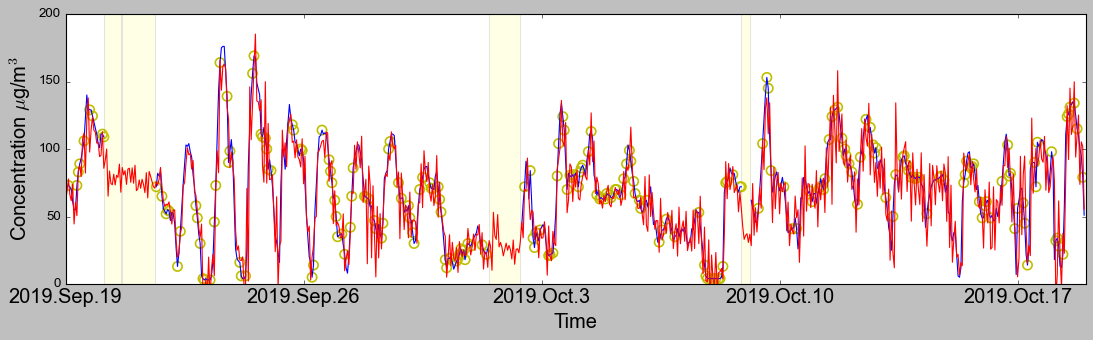

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


fig = plt.figure(figsize = (15, 4.5))
plt.style.use('classic')
plt.rcParams['font.family'] = 'Arial'
ax = fig.add_axes([0.18, 0.20, 0.85, 0.75])
# ax = fig.add_axes([0, 0, 1, 1])
ax.set_facecolor('white')
# ax.set_facecolor((1.0, 0.47, 0.42))
pollutant = 5 #66#163#35#67
start_time = 100 #3312
end_time = 820 #3528
array = test_ground_truth[pollutant, start_time:end_time]
nonzero = [[]]
pos = np.where(array != 0)
seg = 0
for i in range(len(pos[0])):
    if (i == len(pos[0]) - 1) or (pos[0][i + 1] == pos[0][i] + 1): # continuous
        nonzero[seg].append(pos[0][i])
    if (i != len(pos[0]) - 1) and (pos[0][i + 1] != pos[0][i] + 1): # dis continuous
        nonzero[seg].append(pos[0][i])
        nonzero.append([])
        seg += 1

Scatter_point = []
continuous_seg = []
for i in range(len(nonzero)):
    if len(nonzero[i]) == 1:
        Scatter_point.append(nonzero[i][0])
    else:
        continuous_seg.append(nonzero[i])

for i in range(len(continuous_seg)):
    plt.plot(continuous_seg[i], array[continuous_seg[i]], label = 'concentration', marker='', markerfacecolor='b', markersize=8, color='blue', linewidth=1)
# plt.plot(array[pos], label = 'concentration', marker='', markerfacecolor='blue', markersize=8, color='red', linewidth=2)

# plt.scatter(Scatter_point, array[Scatter_point], facecolors='none', edgecolors='b', s=3)
# plt.plot(test_ground_truth[pollutant, start_time:end_time], label = 'Ground Truth', marker='', markerfacecolor='blue', markersize=8, color='blue', linewidth=1)
array_ground_truth = test_ground_truth[pollutant, start_time:end_time]
pos = np.where(array_ground_truth == 0)
zero = [[]]
seg = 0
for i in range(len(pos[0])):
    if (i == len(pos[0]) - 1) or (pos[0][i + 1] == pos[0][i] + 1):
        zero[seg].append(pos[0][i])
    if (i != len(pos[0]) - 1) and (pos[0][i + 1] != pos[0][i] + 1):
        zero[seg].append(pos[0][i])
        zero.append([])
        seg += 1

RM = []
NM = []
for i in range(len(zero)):
    if len(zero[i]) == 1:
        RM.append(zero[i][0])
    else:
        NM.append(zero[i])


# plt.yticks(np.arange(0, 150, 40), [0, 40, 80, 120])
# plt.xticks(np.arange(0, 230, 10))#, [0, 50, 100, 150, 200, 250])
plt.ylim(0, 200)
plt.xlim(0, 720)
ax.set_ylabel("Concentration $\mu$g/m$^3$", fontsize=18)
ax.set_xlabel("Time", fontsize=18)
# ax.set_title("Speed prediction for sensor No.%d"%(pollutant))
# ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
# plt.scatter(RM, array[np.array(RM)], facecolors='none', edgecolors='y', s=30)
array_sparse = test_set[pollutant, start_time:end_time]
pos = np.where((array_sparse == 0) & (array_ground_truth != 0))


plt.scatter(pos, array_ground_truth[pos], facecolors='none', edgecolors='y', s=70, linewidth=1.5)
plt.plot(mat_hat[pollutant, start_time : end_time], label = 'Predicted', marker='', markerfacecolor='blue', markersize=8, color='red', linewidth=1)

for i in range(len(NM)):
    ax.add_patch(patches.Rectangle((NM[i][0] - 1, 0), NM[i][-1] - NM[i][0] + 1, 200, alpha = 0.1, facecolor = 'yellow'))
plt.xticks(np.arange(0, 720, 168), ["2019.Sep.19",  "2019.Sep.26", 
                                        "2019.Oct.3", "2019.Oct.10", 
                                   "2019.Oct.17"], fontsize=18)
# plt.legend(loc = 'best')
file_n = 'prediction_shanghai_trmf_pm0.4' + '.png'
plt.savefig(file_n, bbox_inches = 'tight')
plt.show()